# **IL DATASET**

Dataset: Synthetic Financial Datasets For Fraud Detection da Kaggle (https://www.kaggle.com/datasets/ealaxi/paysim1/data). Il nostro scopo è classificare le operazioni finanziarie come truffe o non-truffe.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [4]:
df = pd.read_csv('findataTOT.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Diamo una prima occhiata al dataset: vediamo se contiene valori NaN e quante operazioni fraudolente contiene.

In [5]:
df.shape

(6362620, 11)

In [ ]:
df.info()

missing_values = df.isnull().sum()
print("Numero di valori NaN per colonna:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Numero di valori NaN per colonna:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
fraud_df = df[df['isFraud'] == 1]
fraud_df.count()

step              8213
type              8213
amount            8213
nameOrig          8213
oldbalanceOrg     8213
newbalanceOrig    8213
nameDest          8213
oldbalanceDest    8213
newbalanceDest    8213
isFraud           8213
isFlaggedFraud    8213
dtype: int64

Abbiamo un dataset di 6.3 milioni di righe e 11 colonne. Di queste operazioni solamente 8213 sono truffe, inoltre non risultano valori mancanti.

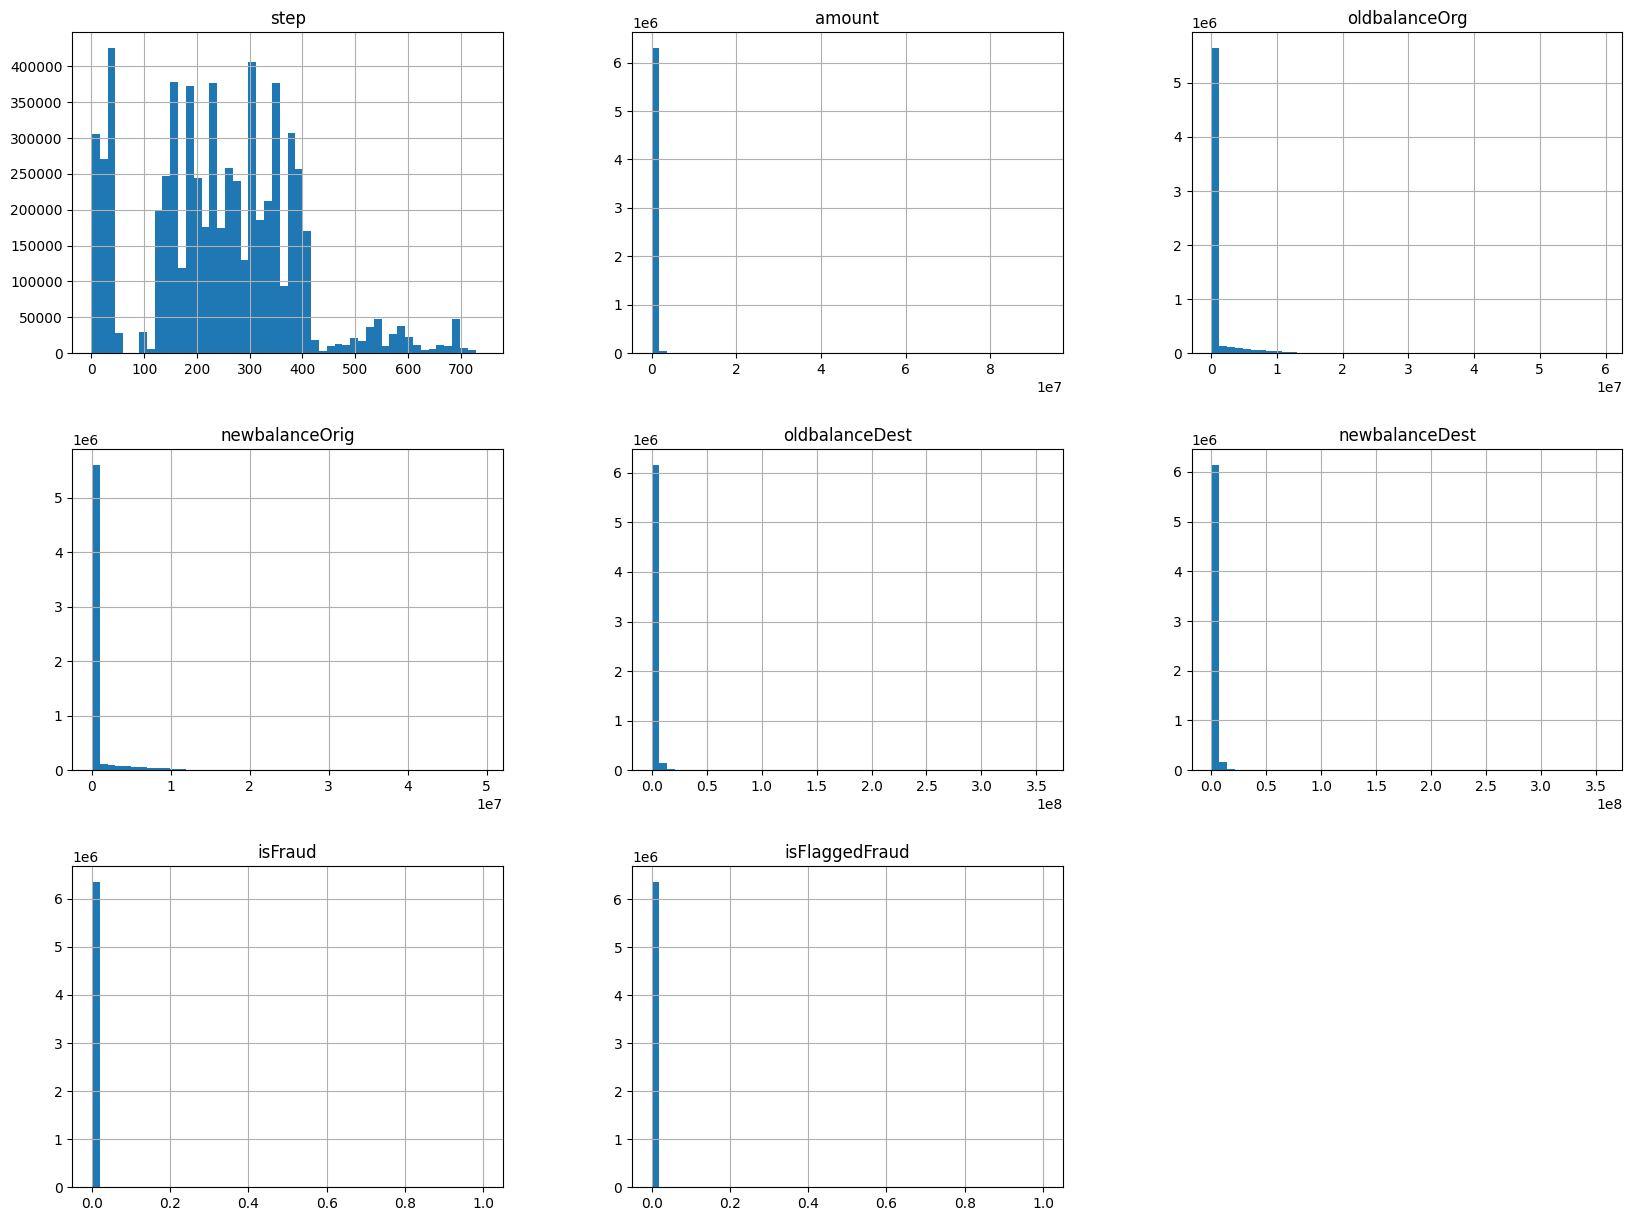

In [ ]:
df = df.hist(bins=50, figsize=(20, 15))
plt.show()

Il primo grafico ci dice quanto ci mettono le operazioni a essere portate a termine, il secondo ci dice l ammontare delle vari operazioni finanziarie, il terzo e quarto grafico ci dicono i saldi dei mittenti prima e dopo l operazione, mentre il quinto e sesto dei destinatari. Il settimo ci dice quante di queste operazioni siano fraudolente, salta subito all occhio che solo una piccolissima parte dei queste lo è. L ultimo grafico mostra quante di queste frodi siano state segnalate, non ci interessa troppo.

# **FEATURE ENGINEERING E STUDIO DEI DATI**

Creaiamo una colonna che potrebbe esserci utile, che riporti le iniziali, C oppure M, del tipo di conto del destinatario e del mittente, dato che iniziano entrambi con la lettera C e terminano con C o con M. Dopodiché eliminiamo tutte quelle che non ci servono.

In [6]:
df['initials'] = df['nameOrig'].str[0] + df['nameDest'].str[0]
df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'nameOrig', 'nameDest'], inplace=True)
df.head()

,step,type,amount,isFraud,initials
0,1,PAYMENT,9839.64,0,CM
1,1,PAYMENT,1864.28,0,CM
2,1,TRANSFER,181.00,1,CC
3,1,CASH_OUT,181.00,1,CC
4,1,PAYMENT,11668.14,0,CM


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   step      int64  
 1   type      object 
 2   amount    float64
 3   isFraud   int64  
 4   initials  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 242.7+ MB


Il dataset adesso è molto più leggibile e compatto.
Vediamo a quanto ammontano mediamente le operazioni e quali vengono colpite dalle truffe:

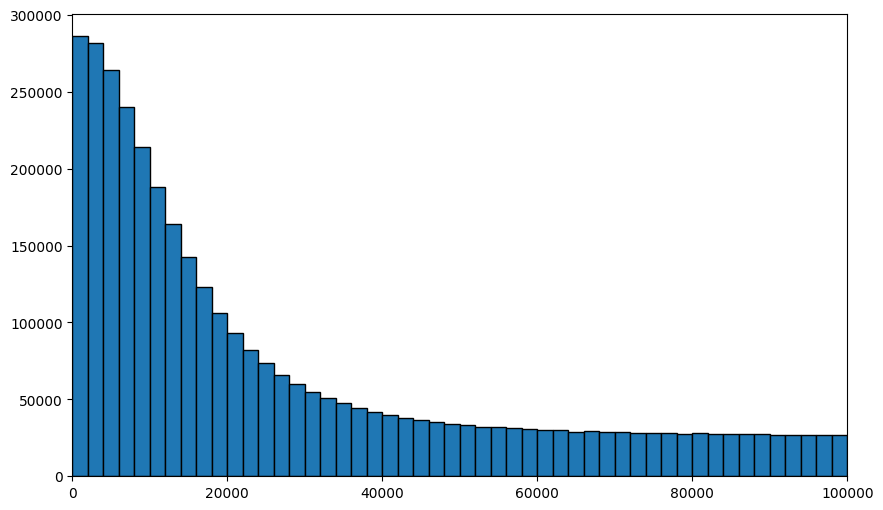

179861.90354913071

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['amount'], bins=50, range=(0, 100000), edgecolor='black')
plt.xlim(0, 100000)

plt.show()

df['amount'].mean()

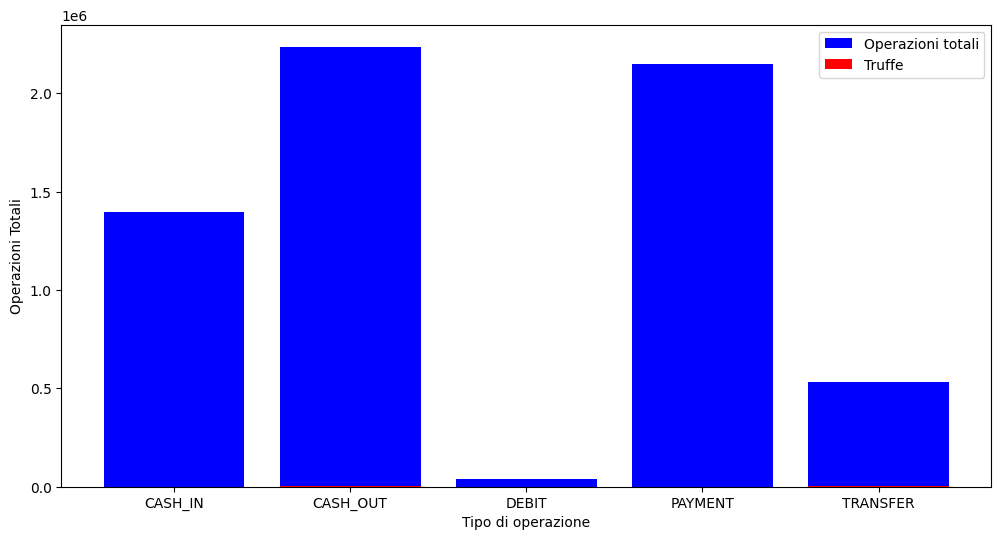

In [ ]:
grouped = df.groupby('type').size()

fraudulent_counts = df[df['isFraud'] == 1].groupby('type').size()

plt.figure(figsize=(12, 6))

plt.bar(grouped.index, grouped.values, color='blue', label='Operazioni totali')
plt.bar(fraudulent_counts.index, fraudulent_counts.values, color='red', label='Truffe')

plt.xlabel('Tipo di operazione')
plt.ylabel('Operazioni Totali')

plt.legend()
plt.show()

Sembra che vengano colpite, solo in minima parte, le operazioni di CASH OUT e TRANSFER. Vediamo in che percentuale

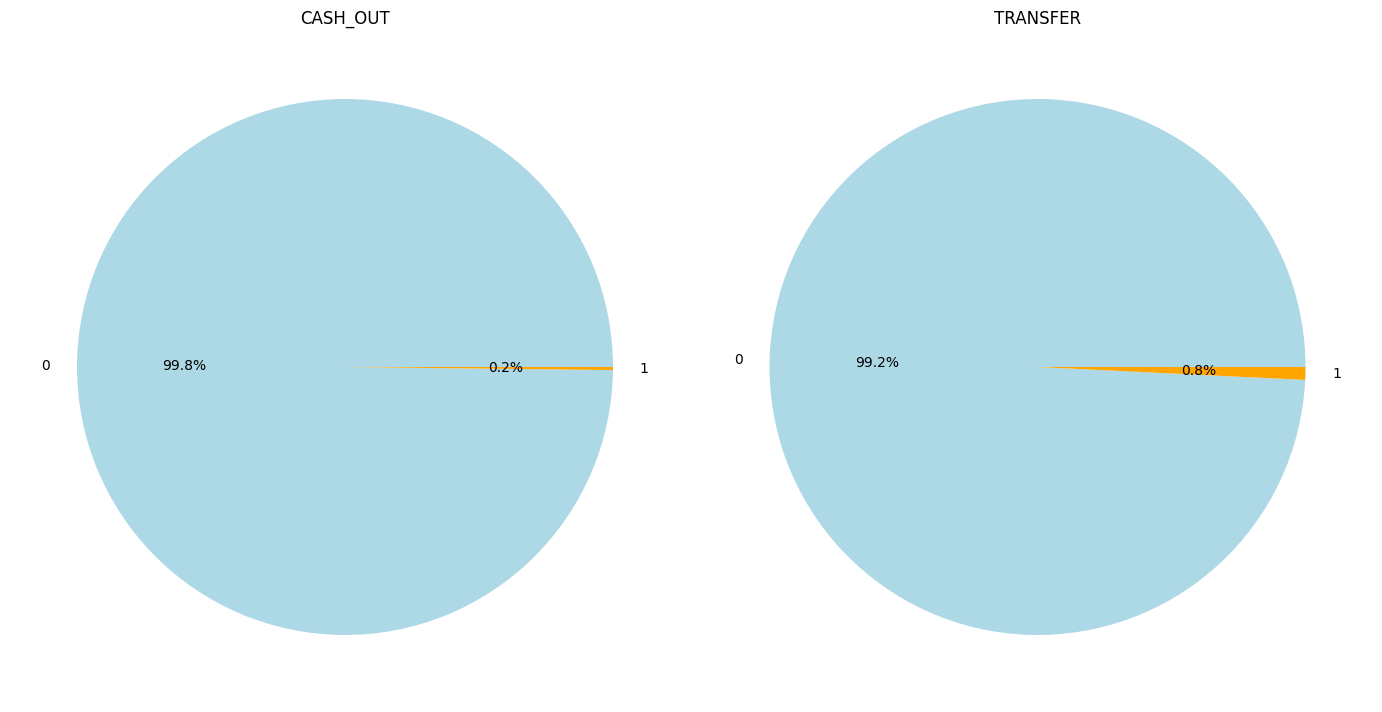

In [ ]:
cash_out = df[df['type'] == 'CASH_OUT']
transfer = df[df['type'] == 'TRANSFER']

cash_out_counts = cash_out['isFraud'].value_counts()
transfer_counts = transfer['isFraud'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Grafico 'CASH_OUT'
axs[0].pie(cash_out_counts, labels=cash_out_counts.index, autopct='%1.1f%%', colors=['lightblue', 'orange'])
axs[0].set_title('CASH_OUT')

# Grafico 'TRANSFER'
axs[1].pie(transfer_counts, labels=transfer_counts.index, autopct='%1.1f%%', colors=['lightblue', 'orange'])
axs[1].set_title('TRANSFER')


plt.tight_layout()
plt.show()

Adesso vediamo a quanto ammontano le truffe:

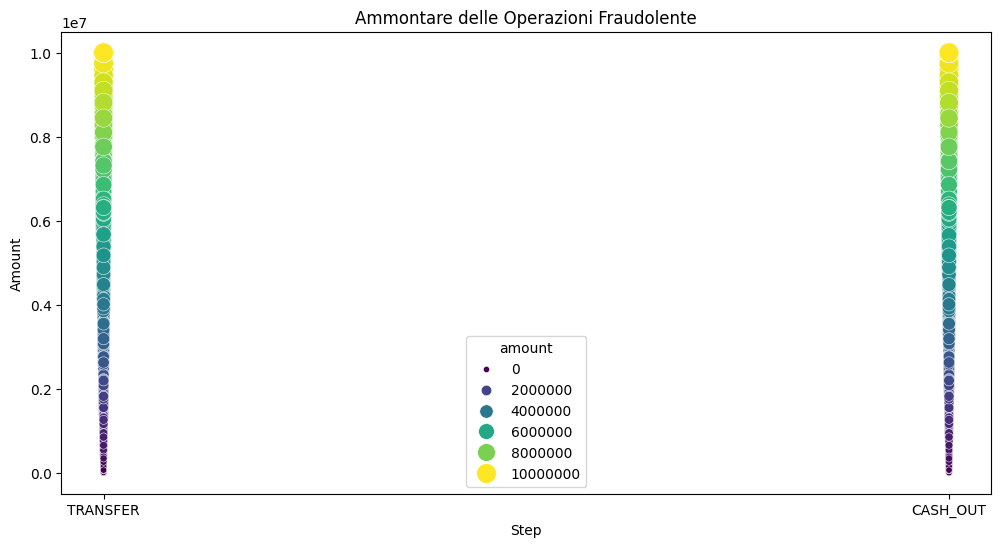

In [ ]:
fraud_df = df[df['isFraud'] == 1]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=fraud_df, x='type', y='amount', hue='amount', palette='viridis', size='amount', sizes=(20, 200))
plt.title('Ammontare delle Operazioni Fraudolente')
plt.xlabel('Step')
plt.ylabel('Amount')
plt.show()

Le operazioni fraudolente vanno da 1 a 10,000,000 di dollari.

Ora vediamo i tipi di conto corrente coinvolti:

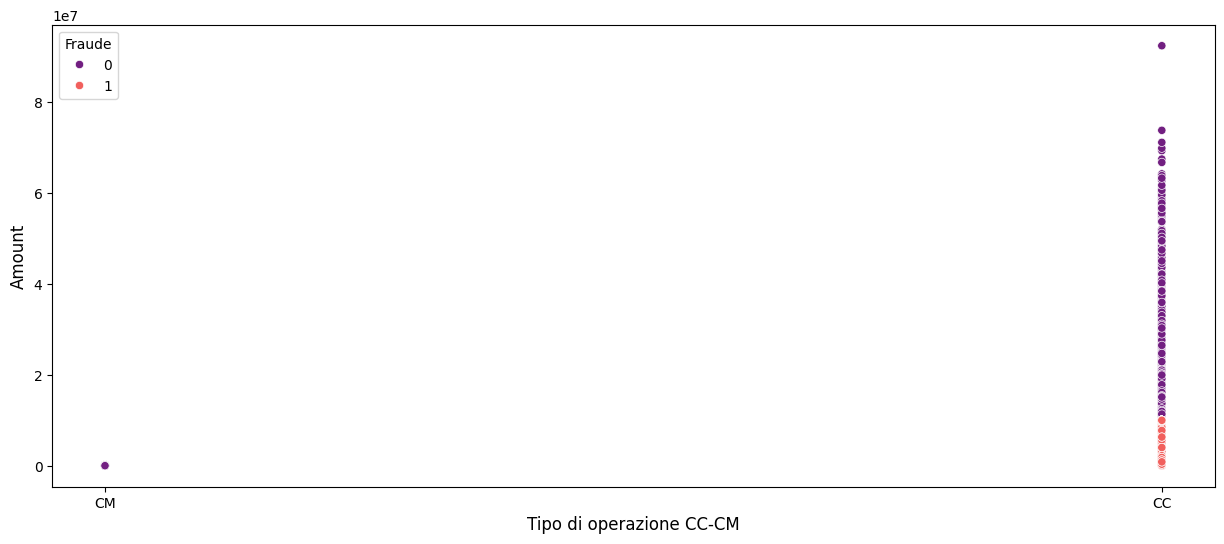

In [ ]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='initials', y='amount', hue='isFraud', data=df)
plt.xlabel('Tipo di operazione CC-CM', fontsize=12)
plt.ylabel('Amount', fontsize=12)

plt.legend(title='Fraude', fontsize=10)

plt.show()

Nelle transizioni CM non si registrano frodi, quelle che invece si registrano in CC non superano la soglia di amount calcolata in precedenza.
Capiamo come ultima cosa quanto durano le operazioni truffe, e calcoliamo il massimo, minimo e media.

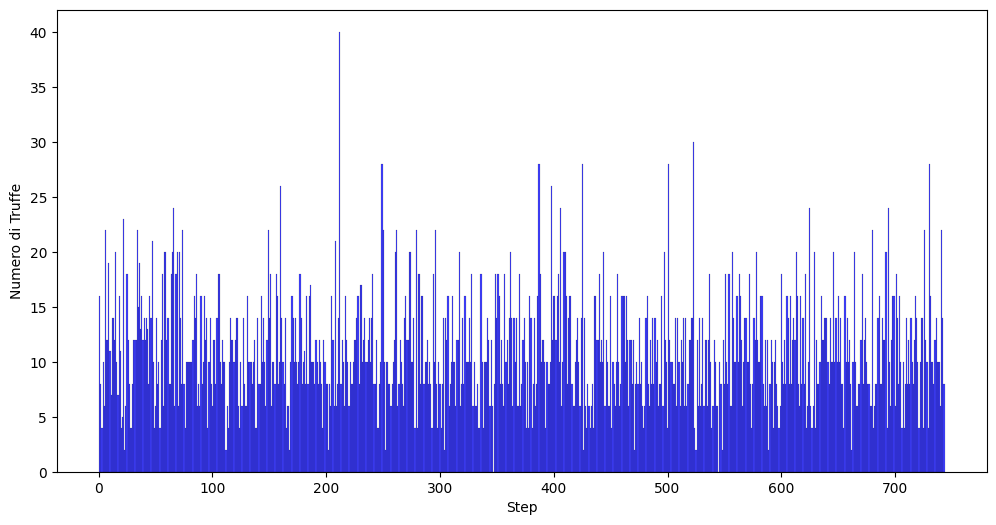

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=fraud_df, x='step', bins=801, discrete=True, kde=False, color='blue')
plt.xlabel('Step')
plt.ylabel('Numero di Truffe')
plt.show()

In [ ]:
max_step_fraud = fraud_df['step'].max()
min_step_fraud = fraud_df['step'].min()
mean_step_fraud = fraud_df['step'].mean()

print("durata massima: ", max_step_fraud)
print("durata minima: ", min_step_fraud)
print("durata media: ", mean_step_fraud)

durata massima:  743
durata minima:  1
durata media:  368.4138560818215


Le durate vanno da 1 a 743 ore e sembrano distribuite abbastanza uniformemente, ma si vedono dei tratti di picco e fondo; ad esempio notiamo che ci sono più di 40 truffe che sono state completate in 210 ore.

Abbiamo adesso una visione d'insieme. Di queste molteplici operazioni solo 8213 sono frodi, queste prevedono solo due tipologie di operazioni, CashOut e Transfer, una sola coppia specifica di tipologie di conto, ovvero CC, un certo range di denaro, e diverse durate.

Cerchiamo adesso se c'è correlazione fra variabili. Poiché alcune colonne contengono str, possiamo creare diverse colonne, una per tipologia di operazione, una per CM e una per CC, che contengano solo 0 e 1 attraverso il metodo get_dummies().
Questo metodo ha un funzionamento simile a OneHotEncoder di scikit-learn, con la differenza che restituisce un dataframe di pandas anziché una matrice di numpy.

In [7]:
df = pd.get_dummies(df, columns=['type', 'initials'])
df.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,initials_CC,initials_CM
0,1,9839.64,0,False,False,False,True,False,False,True
1,1,1864.28,0,False,False,False,True,False,False,True
2,1,181.00,1,False,False,False,False,True,True,False
3,1,181.00,1,False,True,False,False,False,True,False
4,1,11668.14,0,False,False,False,True,False,False,True


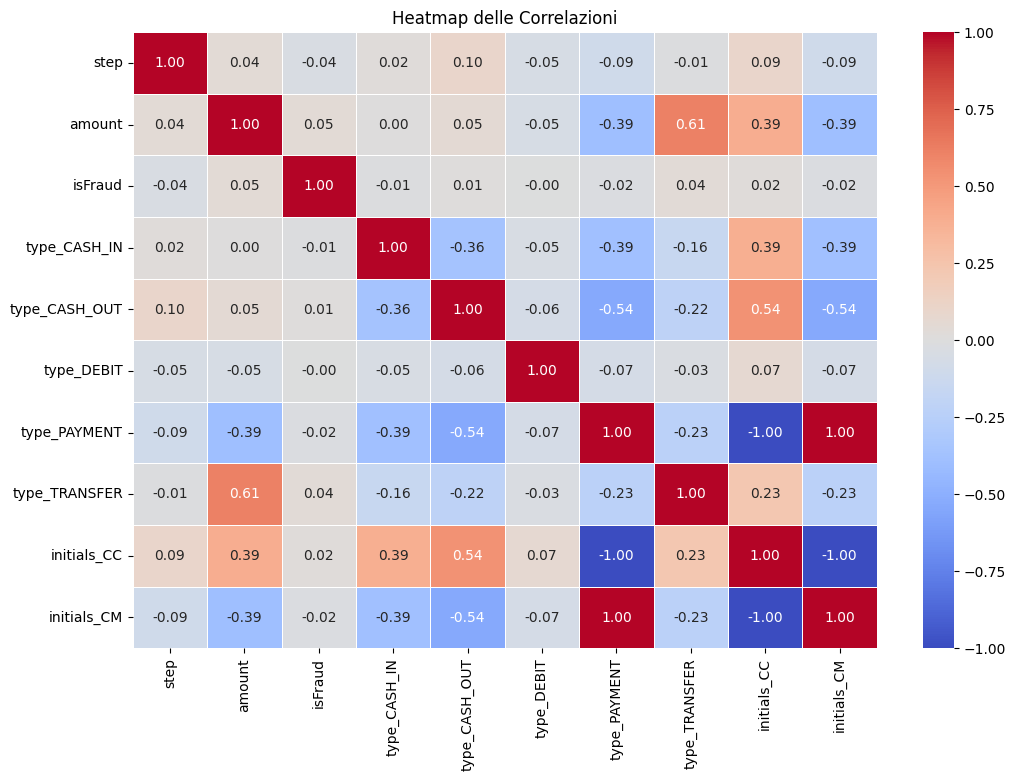

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap delle Correlazioni')
plt.show()

La nostra variabile obiettivo è 'isFraud', che sembra non avere correlazione con nessuna variabile. Dobbiamo bilanciare i dati, questo perché le frodi, sul totale delle operazioni, sono una piccolissima parte.
In questo generi di problemi in cui una varabile, in questo caso binaria, è quasi interamente distribuita solo su un valore, occorre bilanciare il dataset, per esempio ditribuendo 'isFraud' al 50/50.

Usiamo l'Under-sampling e Over-sampling per creare un dataset composto da 200.000 di truffe e 200.000 di non truffe, guardiamo poi nuovamente la correlazione.
Un'altra alternativa sarebbe stata lo Stratified Sampling, per ridurre la dimensione del dataset pur mantenendo la proporzione fra le classi.

In [8]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']
df_combined = pd.concat([X, y], axis=1)

class_counts = df['isFraud'].value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Sotto e Sovracampionamento
df_majority = df_combined[df_combined['isFraud'] == majority_class]
df_majority_under = df_majority.sample(200000, random_state=42)
df_minority = df_combined[df_combined['isFraud'] == minority_class]
df_minority_over = df_minority.sample(200000, replace=True, random_state=42)

df_new = pd.concat([df_majority_under, df_minority_over], ignore_index=True)

# Shuffle
df_new = df_new.sample(frac=1, random_state=42).reset_index(drop=True)

print("Distribuzione delle classi nel nuovo dataframe:")
print(df_new['isFraud'].value_counts())

###NOTA: abbiamo preso solo 400.000 campioni per ottimizzare i tempi

Distribuzione delle classi nel nuovo dataframe:
isFraud
0    200000
1    200000
Name: count, dtype: int64


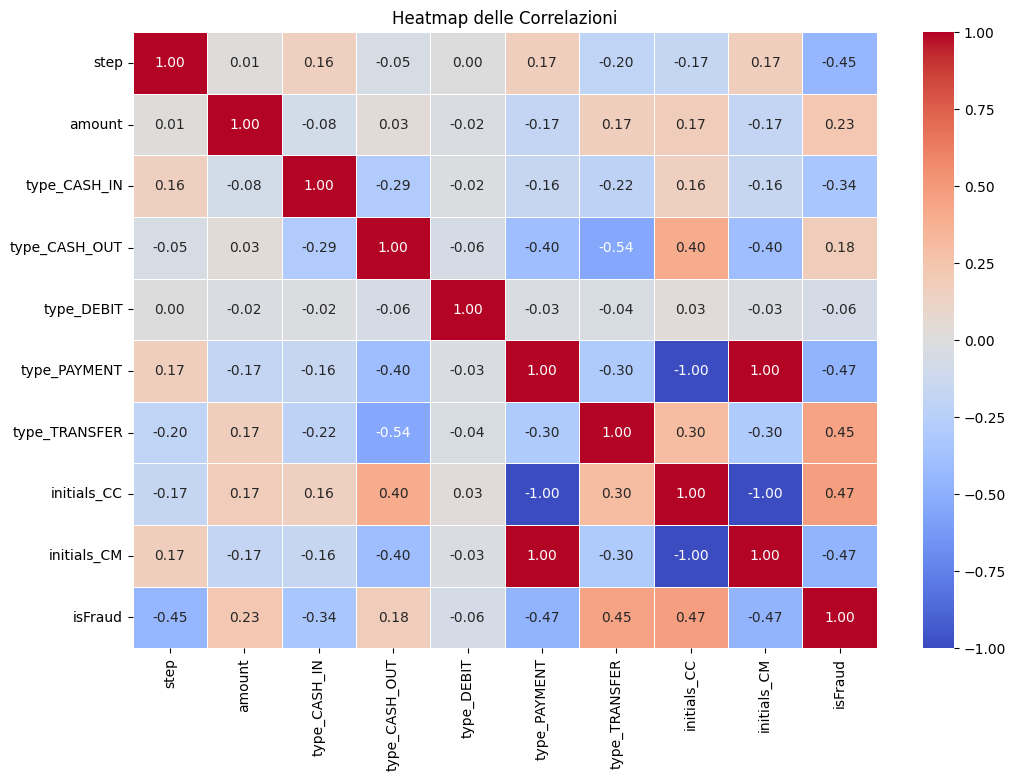

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_new.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap delle Correlazioni')
plt.show()

La situazione sembra migliorata, osserviamo delle correlazioni medie fra 'isFraud' e altre variabili.
Ora dobbiamo gestire le variabili ridondanti, possiamo rimuovere CC e CM per via della forte correlazione fra loro e con Payment.

In [9]:
df_new = df_new.drop(columns=['initials_CC', 'initials_CM'])
df_new.head()

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,469,4640.54,False,False,False,True,False,0
1,230,66984.29,False,True,False,False,False,0
2,228,49912.74,True,False,False,False,False,0
3,19,327189.55,True,False,False,False,False,0
4,85,64344.59,False,True,False,False,False,1


# **ADDESTRAMENTO MODELLI**

Ora che abbiamo diviso il dataset è tempo di addestrare i modelli.
Il dataset è stato diviso in train set e test set in alternativa alla cross-validation per via dei tempi e dei costi computazionali.
Per tutti i modelli implementiamo la standardizzazione, tramite StandardScaler, per portare i dati su scala comune (media 0, deviazione standard 1) di modo da ottimizzarne le prestazioni.

*Modelli*: SVM, random forest, Rete Neurale.

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# **SVM**


In [ ]:
from sklearn.svm import SVC

X = df_new.drop(columns=['isFraud'])
y = df_new['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(random_state=42)

param_grid = {'C': [0.1, 1, 10, 100],}

grid = GridSearchCV(model, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

y_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=17.0min
[CV] END ..............................................C=0.1; total time=17.1min
[CV] END ..............................................C=0.1; total time=18.9min
[CV] END ..............................................C=0.1; total time=15.9min
[CV] END ..............................................C=0.1; total time=18.9min
[CV] END ................................................C=1; total time=21.2min
[CV] END ................................................C=1; total time=26.5min
[CV] END ................................................C=1; total time=18.1min
[CV] END ................................................C=1; total time=22.0min
[CV] END ................................................C=1; total time=18.4min
[CV] END ...............................................C=10; total time=20.9min
[CV] END ........................................

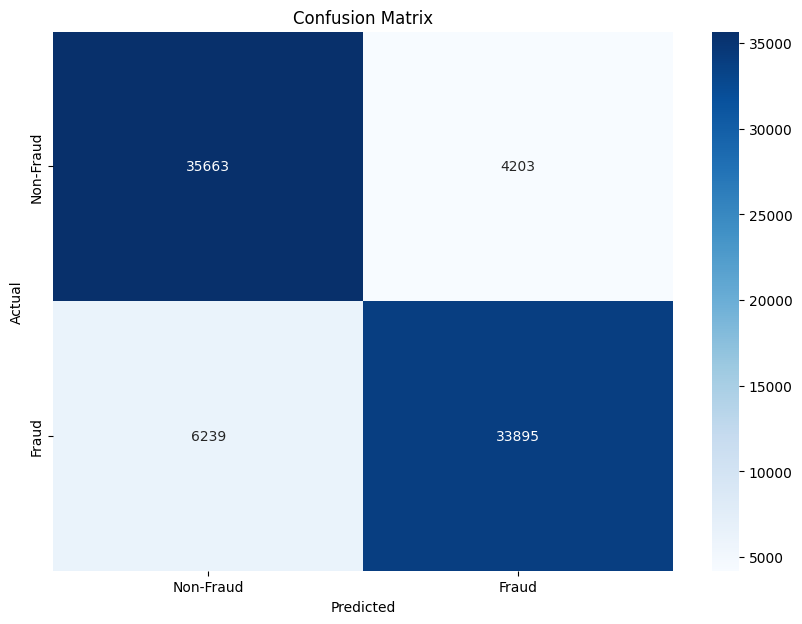

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **RANDOM FOREST**

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...................max_depth=None, n_estimators=100; total time=  31.4s
[CV] END ...................max_depth=None, n_estimators=100; total time=  31.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=  32.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=  32.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=  32.3s
[CV] END ...................max_depth=None, n_estimators=200; total time= 1.2min
[CV] END ...................max_depth=None, n_estimators=200; total time= 1.2min
[CV] END ...................max_depth=None, n_estimators=200; total time= 1.2min
[CV] END .....................max_depth=10, n_estimators=100; total time=  21.3s
[CV] END ...................max_depth=None, n_estimators=200; total time= 1.2min
[CV] END ...................max_depth=None, n_estimators=200; total time= 1.2min
[CV] END .....................max_depth=10, n_es

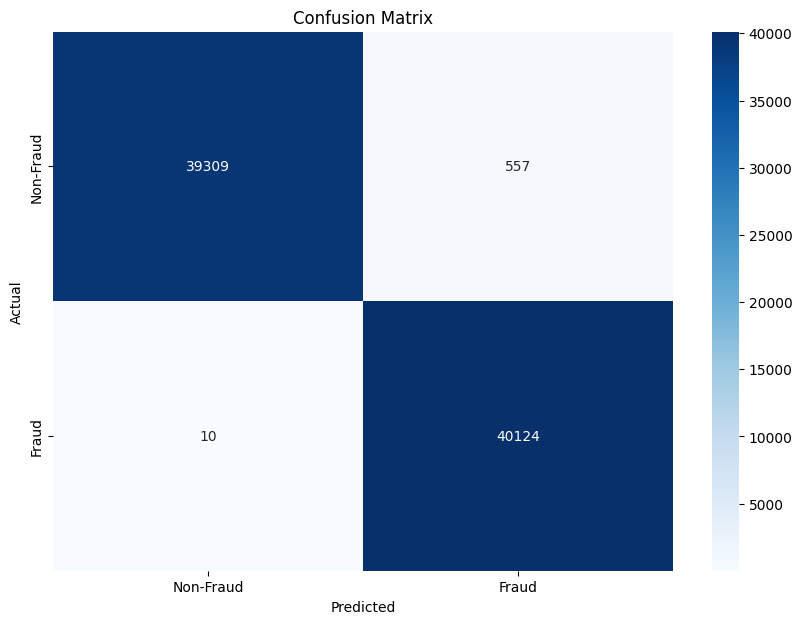

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_new.drop(columns=['isFraud'])
y = df_new['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Migliori iperparametri trovati:", best_params)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **RETE NEURALE**

Per questo modello NON è stata implementata la GrisSearch per motivi di costi computazionali.
In questo caso creiamo una rete composta da due hidden layer con funzione di attivazione ReLu e un layer di output con sigmoid (uno solo perché è un problema binario). Il modello è addestrato utilizzando l'ottimizzatore Adam, per via dell'efficienza computazionale e della poca memoria richiesta, e la funzione di perdita binary cross-entropy (analogo della CCE per i problemi binari).
Per quanto riguarda gli altri iperparametri abbiamo impostato 50 epoche e una batch_size di 10 (è piccola, aggiornerà i pesi frequentemente) di modo da non rischiare l'overfitting.

Epoch 1/50
32000/32000 [==============================] - 115s 4ms/step - loss: 0.2956 - accuracy: 0.8655 - val_loss: 0.2785 - val_accuracy: 0.8720
Epoch 2/50
32000/32000 [==============================] - 108s 3ms/step - loss: 0.2803 - accuracy: 0.8745 - val_loss: 0.2705 - val_accuracy: 0.8819
Epoch 3/50
32000/32000 [==============================] - 95s 3ms/step - loss: 0.2750 - accuracy: 0.8772 - val_loss: 0.2690 - val_accuracy: 0.8801
Epoch 4/50
32000/32000 [==============================] - 101s 3ms/step - loss: 0.2718 - accuracy: 0.8786 - val_loss: 0.2625 - val_accuracy: 0.8841
Epoch 5/50
32000/32000 [==============================] - 103s 3ms/step - loss: 0.2696 - accuracy: 0.8794 - val_loss: 0.2619 - val_accuracy: 0.8856
Epoch 6/50
32000/32000 [==============================] - 94s 3ms/step - loss: 0.2685 - accuracy: 0.8795 - val_loss: 0.2627 - val_accuracy: 0.8838
Epoch 7/50
32000/32000 [==============================] - 96s 3ms/step - loss: 0.2677 - accuracy: 0.8797 - val_los

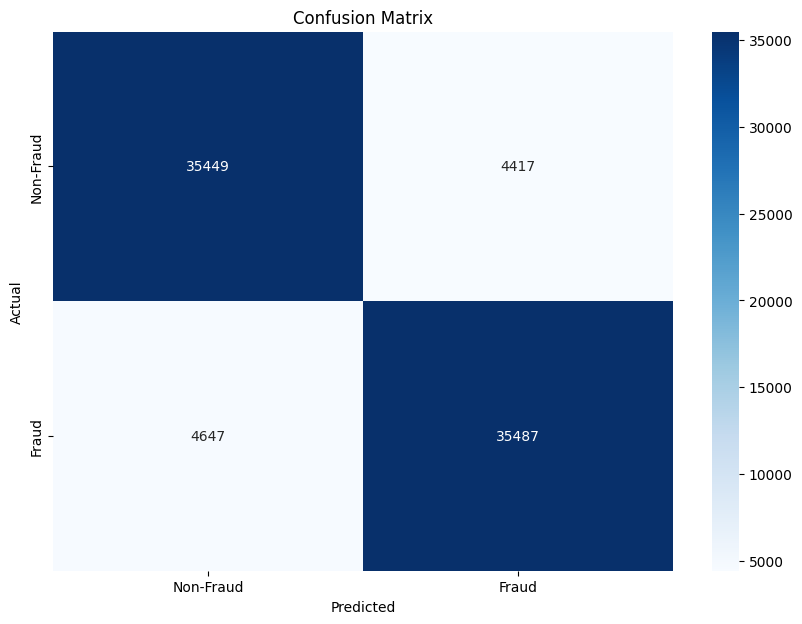

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X = df_new.drop(columns=['isFraud'])
y = df_new['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))
#usiamo xtest e ytest come validation set

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **RISULTATI**

L' SVM ha avuto buoni risultati, con un'accuratezza dell'86.94% e metriche di precisione piuttosto vicine fra loro, indicando una buona capacità di distinzione delle classi, ma ha necessitato di tempi di addestramento più alti rispetto agli altri modelli per via della GridSearch.

La random forest si è rivelato essere il modello migliore, con un'accuratezza del 99.29% e le metriche di precisione tutte vicine a 1; osservando la sua matrice di confusione notiamo che ha commesso solo 567 errori di classificazione su 80,000 previsioni. Gli iperparametri migliori ci dicono che 100 alberi, senza una profondità massima, sono sufficienti per ottenere un modello preciso senza incorrere in overfitting.

La NN mostra precisione e recall ben bilanciati, gli f-1 score sono identici (0.89). Ha una buona accuratezza, pari a 88.67%, ma comunque inferiore alla random forest. Osservando la prima e ultima epoca c'è un lieve miglioramento nell'accuracy (2%) e nella perdita (-4%), una possibile spiegazione è che il modello abbia raggiunto un punto di convergenza nelle prime epoche, con delle buone performance, non ottenendo poi dei miglioramenti significativi. Dei miglioramenti ci sono comunque stati, indicando che probabilmente il modello non sia andato in overfitting (non c'è quindi bisogno di inserire dei layer di dropout o utilizzare la early stopping).